In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import glob
import itertools
import os

from run import Run
from runs_db import db as runs_db

[('martak', 89), ('gcp', 57), ('deepnet2', 38), ('acer', 6)]


In [2]:
log_path = '/home/fiit/logs'
runs = []

for server in runs_db:
    paths = glob.glob(os.path.join(log_path, server, '*'))
    paths = iter(sorted(paths))

    try:
        for (number, type_, code) in runs_db[server]:
            for _ in range(number):
                try:
                    path = next(paths)
                    runs.append(Run(path, type_, code))
                except KeyError:
                    print(path)
    except StopIteration:
        pass


In [3]:
tasks = ['dep', 'lmo', 'ner', 'pos']
langs = ['cs', 'de', 'en', 'es']

task_metr = {
    'dep': 'las',
    'lmo': 'perplexity',
    'ner': 'chunk_f1',
    'pos': 'acc'
}

task_max = {
    'dep': True,
    'lmo': False,
    'ner': True,
    'pos': True
}

def draw_graphs(metric_func, tasks, langs, role, run_codes=None, run_types=None):
    fig, axes = plt.subplots(len(tasks), len(langs), figsize=(5*len(langs), 4*len(tasks)), squeeze=False)

    relevant_runs = ['vanilla']

    for task, lang in itertools.product(tasks, langs):
        for run in runs:
            if (
                run.contains(task, lang) and
                (run_codes is None or run.code in run_codes) and
                (run_types is None or run.type in run_types)
            ):

                history = run.history(
                    metric=metric_func(task),
                    task=task,
                    language=lang,
                    role=role)
                axes[tasks.index(task), langs.index(lang)].plot(list(history), label=f'{run.code}-{run.type}')

    for ax, col in zip(axes[0], langs):
        ax.set_title(col)

    for ax, row in zip(axes[:, 0], tasks):
        ax.set_ylabel(row, rotation=0, size='large')
        
    for ax_row in axes:
        for ax in ax_row:
            ax.legend()

    plt.show()
    
def print_results(metric_func, metric_max_func, tasks, langs, run_codes=None, run_types=None):
    
    for task, lang in itertools.product(tasks, langs):
        for run in runs:
            if (
                run.contains(task, lang) and
                (run_codes is None or run.code in run_codes) and
                (run_types is None or run.type in run_types)
            ):
                result = run.metric_eval(
                    metric=metric_func(task),
                    max_=metric_max_func(task),
                    task=task,
                    language=lang)
                print(f'{run.code} {run.type} {task} {lang}: {result}')
        

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


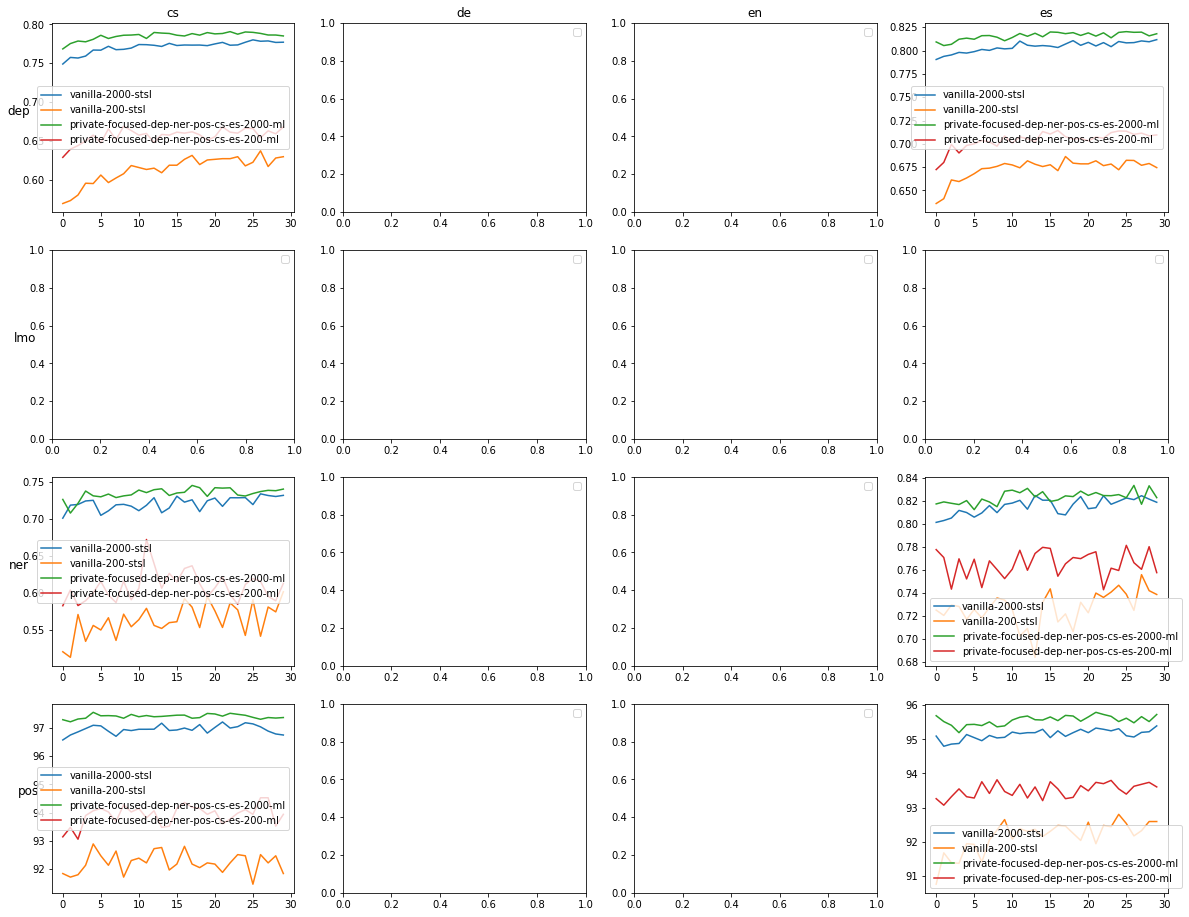

private-focused-0.75-dep-ner-pos-cs-es mt dep cs: (0.8889867279963387, 27)
private-focused-0.75-dep-ner-pos-cs-es ml dep cs: (0.8959674195772191, 30)
private-focused-0.75-dep-ner-pos-cs-es ml dep es: (0.8661901746132272, 25)
private-focused-0.75-dep-ner-pos-cs-es mt ner cs: (0.7782071097372488, 10)
private-focused-0.75-dep-ner-pos-cs-es ml ner cs: (0.7799921844470497, 24)
private-focused-0.75-dep-ner-pos-cs-es ml ner es: (0.8618489390117229, 4)
private-focused-0.75-dep-ner-pos-cs-es mt pos cs: (99.04645490936687, 28)
private-focused-0.75-dep-ner-pos-cs-es ml pos cs: (99.0470342198715, 21)
private-focused-0.75-dep-ner-pos-cs-es mt pos es: (96.52583009137791, 2)
private-focused-0.75-dep-ner-pos-cs-es ml pos es: (96.7067764407853, 2)
vanilla stsl dep cs: (0.891639970107578, 29)
vanilla stsl dep de: (0.7992988067412966, 26)
vanilla stsl dep en: (0.8491886861166188, 27)
vanilla stsl dep es: (0.8651044965167828, 20)
vanilla stsl lmo cs: (16.142887644975684, 30)
vanilla stsl lmo de: (17.14503

In [5]:
draw_graphs(lambda task: task_metr[task], tasks, langs, 'test',
            [
             'vanilla-2000',
             'vanilla-200',
             'private-focused-dep-ner-pos-cs-es-2000',
             'private-focused-dep-ner-pos-cs-es-200'
            ],
            ['stsl', 'ml'])
print_results(lambda task: task_metr[task], lambda task: task_max[task], tasks, langs,
            [
             'private-focused-0.75-dep-ner-pos-cs-es',
            ],
            ['mt', 'ml'])
print_results(lambda task: task_metr[task], lambda task: task_max[task], tasks, langs,
            [
             'vanilla',
            ],
            ['stsl'])

In [ ]:
draw_graphs(lambda task: task_metr[task], tasks, langs, 'test', ['vanilla'])

In [ ]:
draw_graphs(lambda task: task_metr[task], tasks, langs, 'test',
            run_codes=['vanilla', 'vanilla300', 'vanilla400'],
            run_types=['mtml'])